# HealthCare ML Project
## 1. import  Data & libraries

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb 
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu, pointbiserialr


In [9]:
df=pd.read_csv('data/training_v2.csv')

In [10]:
df.head()


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [11]:
print(df.size)

17058618


## 2. Hospital Death distribution


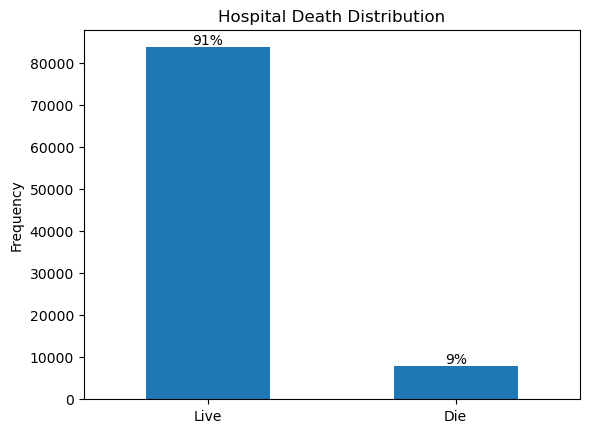

In [12]:
# Assuming data is your DataFrame with the "hospital_death" column
df["hospital_death"].value_counts().sort_index().plot(kind='bar')

# Adding labels and title
plt.ylabel('Frequency')
plt.title('Hospital Death Distribution')

# Adding percentage annotations on top of the bars
total_count = len(df["hospital_death"])
for i, count in enumerate(df["hospital_death"].value_counts().sort_index()):
    percent = count / total_count * 100
    plt.text(i, count + 20, f'{percent:.0f}%', ha='center', va='bottom')
plt.xticks([0,1],["Live",'Die'],rotation=0)
# Show the plot
plt.show()

## 3. Exploring Variables Correlated with Hospital Deaths

The point biserial correlation is used to measure the relationship between a binary variable, x, and a continuous variable, y. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply a determinative relationship.

In [13]:
#define  continious and binary columns
binary_columns = df.columns[(df.nunique() <= 4) ]
continious_columns= df.columns[(df.nunique() >=10) & ((df.dtypes == 'int64')|(df.dtypes == 'float64'))]


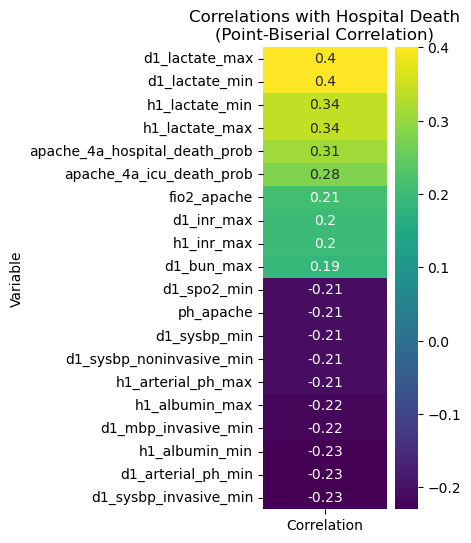

In [14]:


# Calculate the correlation matrix
result = []

for column in continious_columns:
    temp_df = df.loc[:, ["hospital_death", column]].dropna()
    correlation, p_value = pointbiserialr(temp_df['hospital_death'], temp_df[column])
    result.append((column, np.round(correlation, 2), p_value))

# Create a DataFrame from the result
correlation_df = pd.DataFrame(result, columns=['Variable', 'Correlation', 'P-Value']).sort_values(by='Correlation', ascending=False)
correlation_df = correlation_df.set_index('Variable')

# Select the first and last 10 rows
edge_correlation_df = pd.concat([correlation_df.head(10), correlation_df.tail(10)])

# Plotting the heatmap
plt.figure(figsize=(2, 6))
cmap = 'viridis'
sb.heatmap(pd.DataFrame(edge_correlation_df.loc[:, 'Correlation']), annot=True, fmt="g", cmap=cmap)

# Adding title and adjusting plot
plt.title('Correlations with Hospital Death\n(Point-Biserial Correlation)')
plt.show()

## Exploring of high correlated features


we will explore the high correlated features:
1. null values distirbution and find smart method to fill it
2. find the distribution of the correalted values and the taget column (heatlh/death)
3. Colinearity between features
https://medium.com/future-vision/collinearity-what-it-means-why-its-bad-and-how-does-it-affect-other-models-94e1db984168


In [78]:
edge_correlation_df

,Correlation,P-Value
Variable,,
d1_lactate_max,0.40,0.000000e+00
d1_lactate_min,0.40,0.000000e+00
h1_lactate_min,0.34,3.828169e-203
h1_lactate_max,0.34,2.600622e-199
apache_4a_hospital_death_prob,0.31,0.000000e+00
apache_4a_icu_death_prob,0.28,0.000000e+00
fio2_apache,0.21,6.100620e-211
d1_inr_max,0.20,1.334432e-297
h1_inr_max,0.20,1.334432e-297


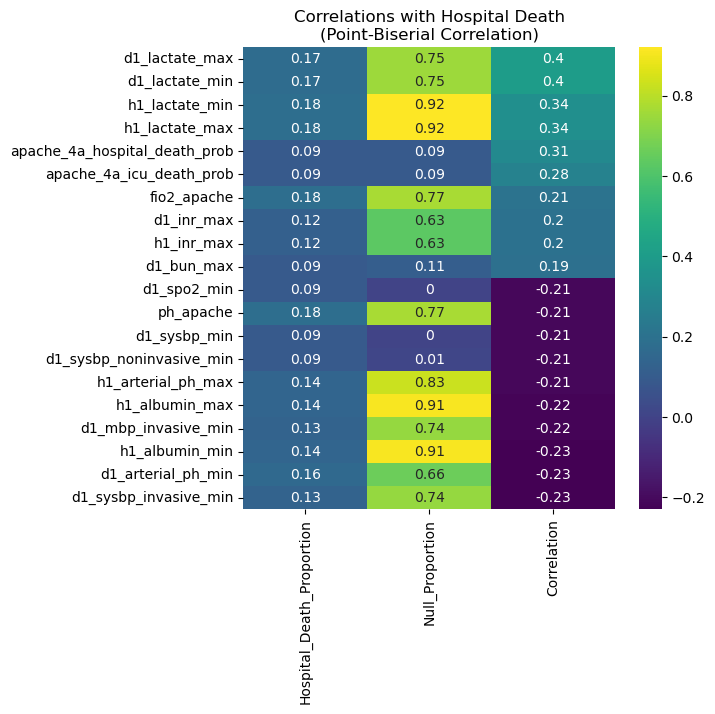

In [85]:
correlated_cols_df=df[edge_correlation_df.index]
result = correlated_cols_df.isna().sum() / len(correlated_cols_df)
dic_corr_col={}
dic_corr_col['dic_prop_col']={}
dic_corr_col['null_prop_col']={}

for col in correlated_cols_df:
    df_dropna_temp=df[[col,"hospital_death"]].dropna()
    dic_corr_col['dic_prop_col'][col]=df_dropna_temp["hospital_death"].sum()/len(df_dropna_temp["hospital_death"])
    dic_corr_col['null_prop_col'][col]=df[col].isna().sum() / len(correlated_cols_df)
df_correlated_results=pd.DataFrame(data=dic_corr_col)
df_correlated_results.rename(columns={"dic_prop_col": "Hospital_Death_Proportion", "null_prop_col": "Null_Proportion"},inplace=True)
df_correlated_results["Correlation"]=edge_correlation_df["Correlation"]
df_correlated_results = df_correlated_results.round({'Null_Proportion': 2, 'Hospital_Death_Proportion': 2,'Correlation':2})
# Plotting the heatmap
plt.figure(figsize=(6, 6))
cmap = 'viridis'
sb.heatmap(pd.DataFrame(df_correlated_results.loc[:, :]), annot=True, fmt="g", cmap=cmap)

# Adding title and adjusting plot
plt.title('Correlations with Hospital Death\n(Point-Biserial Correlation)')
plt.show()

Index(['d1_lactate_max', 'd1_lactate_min', 'h1_lactate_min', 'h1_lactate_max',
       'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob',
       'fio2_apache', 'd1_inr_max', 'h1_inr_max', 'd1_bun_max', 'd1_spo2_min',
       'ph_apache', 'd1_sysbp_min', 'd1_sysbp_noninvasive_min',
       'h1_arterial_ph_max', 'h1_albumin_max', 'd1_mbp_invasive_min',
       'h1_albumin_min', 'd1_arterial_ph_min', 'd1_sysbp_invasive_min'],
      dtype='object')

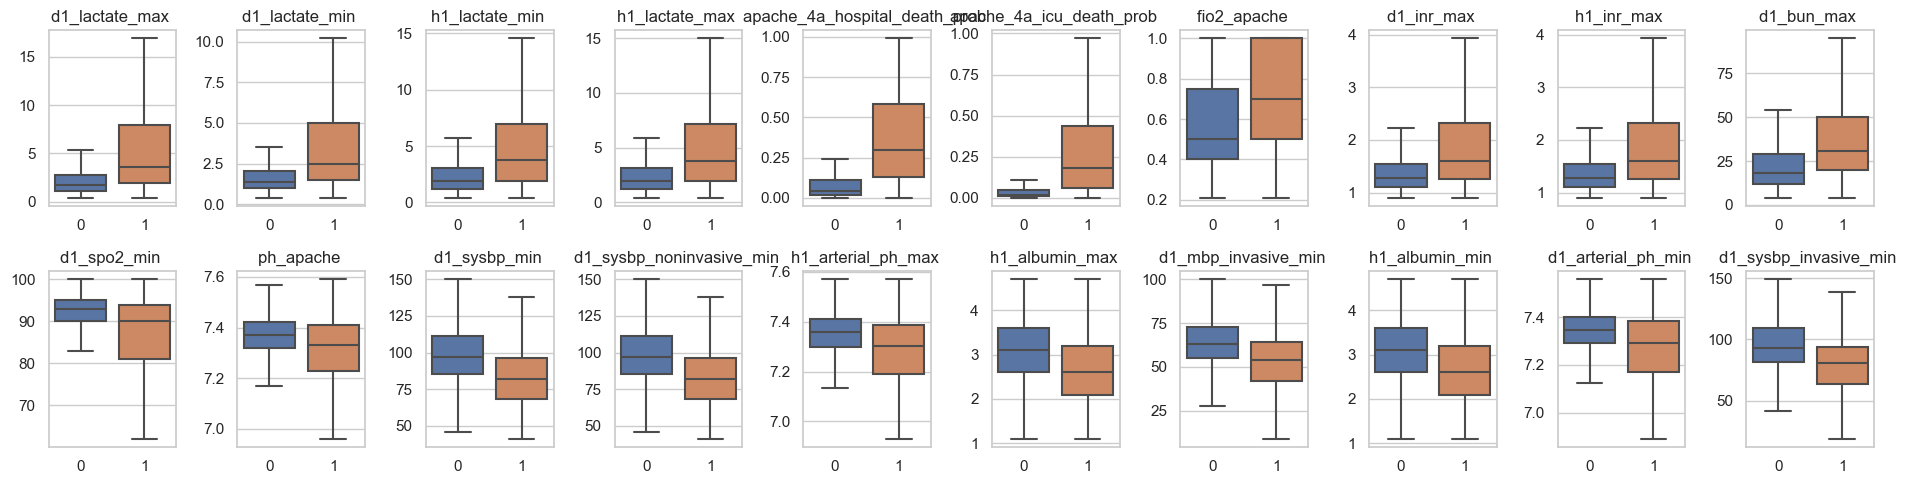

In [129]:

# Set up the matplotlib figure

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(19, 5))

# Iterate through each column and create box plots for each value of 'hospital_death'
for i, col in enumerate(correlated_cols_df.columns):
    r = i // 10  # Determine the row index
    c = i % 10   # Determine the column index
    sb.boxplot(x="hospital_death", y=col, data=df, ax=axes[r,c],showfliers =False)
    
    axes[r, c].set_title(f"{col} ")

    # Remove x-axis and y-axis label
    axes[r, c].set_xlabel('')
    axes[r, c].set_ylabel('')


    # Remove ticks
    axes[r, c].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    

# Create a single legend
legend_labels = [0,1]
plt.setp(axes[-1, :], xlabel='')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

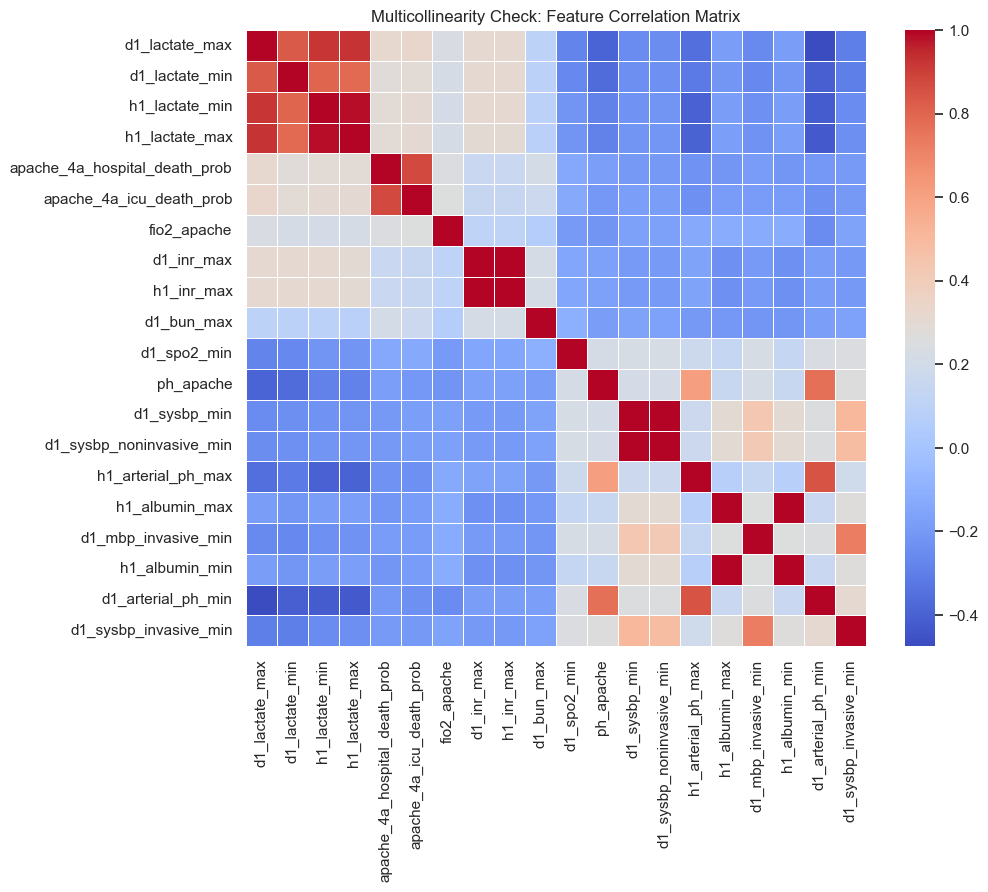

In [136]:
# Set the style for seaborn
sb.set(style="whitegrid")

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sb.heatmap(correlated_cols_df.corr(), cmap='coolwarm', linewidths=.5)

# Add a title highlighting multicollinearity
plt.title("Multicollinearity Check: Feature Correlation Matrix")

# Show the plot
plt.show()

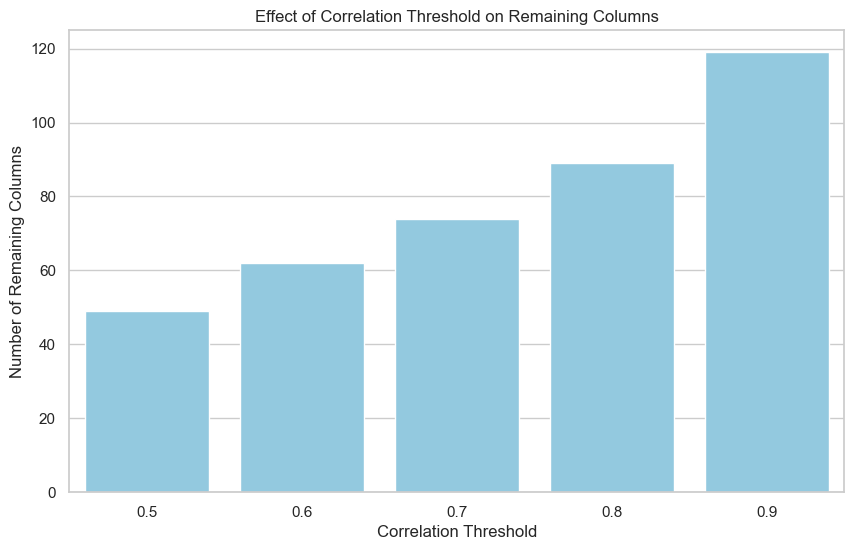

In [231]:

thresholds = np.arange(0.5, 0.95, 0.1)

# Initialize an empty list to store the results
results = []

# Loop through each threshold and count remaining columns
for threshold in thresholds:
    # Create a mask for highly correlated columns
    mask = np.triu(np.abs(correlation_matrix) > threshold, k=1)
    
    # Count the number of columns that are not highly correlated
    remaining_columns_count = np.sum(np.sum(mask, axis=1) == 0)
    
    # Append the results to the list
    results.append({'Correlation_Threshold': threshold, 'Remaining_Columns': remaining_columns_count})

# Convert the list of dictionaries to a DataFrame using pd.concat
results_df = pd.DataFrame(results)
results_df["Correlation_Threshold"]=results_df["Correlation_Threshold"].apply(lambda x: np.round(x,1))
# Plotting the bar plot using Seaborn
plt.figure(figsize=(10, 6))
sb.barplot(x='Correlation_Threshold', y='Remaining_Columns', data=results_df, color='skyblue')
plt.xlabel('Correlation Threshold')
plt.ylabel('Number of Remaining Columns')
plt.title('Effect of Correlation Threshold on Remaining Columns')
plt.show()

## 4. Explorating Null Values in the Dataset







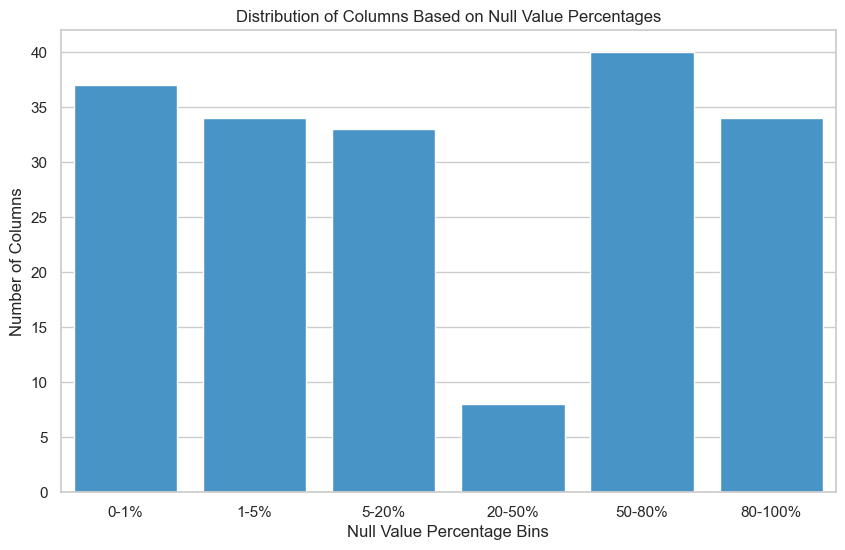

In [130]:
# Calculate the percentage of null values in each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Define the bins for categorization
bins = [-0.1, 1, 5, 20, 50, 80, 100]

# Create a new column indicating the bin for each column
bin_labels = ['0-1%', '1-5%', '5-20%', '20-50%', '50-80%', '80-100%']
null_bins = pd.cut(null_percentages, bins, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = null_bins.value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sb.barplot(x=bin_counts.index, y=bin_counts.values,color='#3498db')
plt.xlabel('Null Value Percentage Bins')
plt.ylabel('Number of Columns')
plt.title('Distribution of Columns Based on Null Value Percentages')
plt.show()

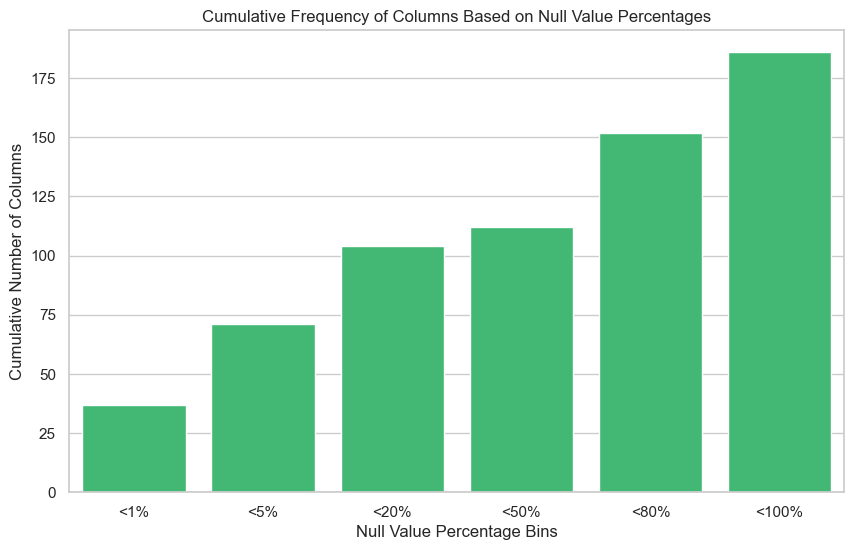

In [131]:
# Calculate the percentage of null values in each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Define the bins for categorization
bins = [-0.1, 1, 5, 20, 50, 80, 100]

# Create a new column indicating the bin for each column
bin_labels = ['<1%', '<5%', '<20%', '<50%', '<80%', '<100%']
null_bins = pd.cut(null_percentages, bins, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = null_bins.value_counts().sort_index()

# Calculate the cumulative frequency
cumulative_freq = bin_counts.cumsum()

# Create a bar plot for cumulative frequency
plt.figure(figsize=(10, 6))
sb.barplot(x=cumulative_freq.index, y=cumulative_freq.values, color='#2ecc71')
plt.xlabel('Null Value Percentage Bins')
plt.ylabel('Cumulative Number of Columns')
plt.title('Cumulative Frequency of Columns Based on Null Value Percentages')
plt.show()

## 5. Mann-Whitney U Test: Live vs. Deceased Groups

In [345]:
group1 = df[df["hospital_death"] == 0]
group2 = df[df["hospital_death"] == 1]

# Create a DataFrame to store p-values, means, and percentage differences
result_df = pd.DataFrame(columns=['Column', 'P-Value', 'Mean_Group_live', 'Mean_Group_die', 'Percentage Difference'])

# Iterate through each column in the DataFrame
for column in continious_columns:
    if column != "hospital_death":
        # Perform the Mann-Whitney U test for the current column
        stat, p_val = mannwhitneyu(group1[column].dropna(), group2[column].dropna(), alternative='two-sided')
        
        # Calculate the mean for each group
        mean_group1 = group1[column].mean()
        mean_group2 = group2[column].mean()
        
        # Calculate the percentage difference between the means
        percentage_difference = (np.abs(mean_group1 - mean_group2) / ((mean_group1 + mean_group2) / 2)) * 100
        
        # Store the results in the DataFrame
        result_df = pd.concat([result_df, pd.DataFrame({'Column': [column], 
                                                        'P-Value': [np.round(p_val, 3)], 
                                                        'Mean_Group_live': [np.round(mean_group1, 2)],
                                                        'Mean_Group_die': [np.round(mean_group2, 2)],
                                                        'Percentage Difference': [np.round(percentage_difference, 2)]})],
                              ignore_index=True)

# # Adjust p-values for multiple testing (e.g., using Benjamini-Hochberg correction)
# result_df['Adjusted P-Value'] = multipletests(result_df['P-Value'], method='fdr_bh')[1]

# Display the resulting DataFrame


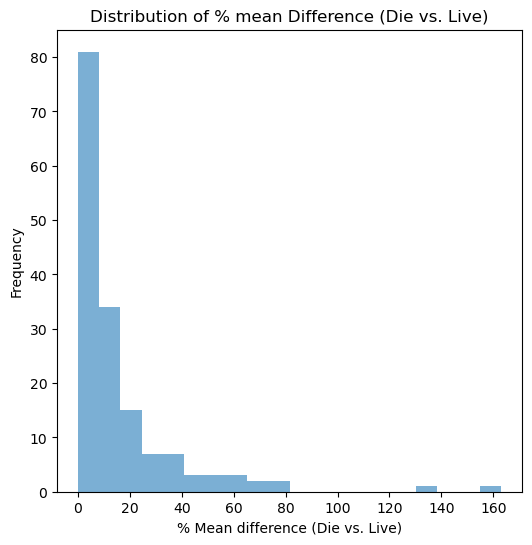

In [346]:
# Assuming your DataFrame is named 'result_df'
plt.figure(figsize=(6, 6))

# Plotting the histogram
result_df["Percentage Difference"].hist(bins=20, color='#7BAFD4')  # Adjust the color as needed

# Adding labels and title
plt.title('Distribution of % mean Difference (Die vs. Live)')
plt.xlabel('% Mean difference (Die vs. Live)')
plt.ylabel('Frequency')

# Adding a grid for better readability
plt.grid(False)

# Show the plot
plt.show()

## 6. Exploring Gender and Ethnicity Disparities 



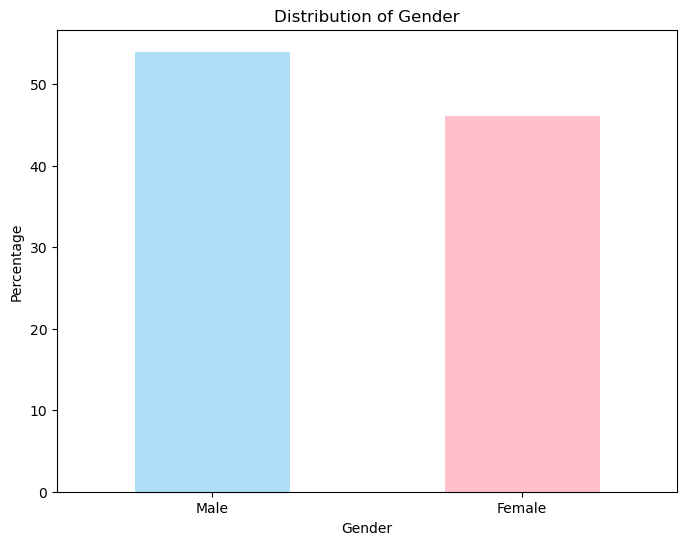

In [348]:

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(8, 6))

# Calculate the percentage distribution
gender_percentage = df['gender'].value_counts(normalize=True) * 100

# Plot the bar chart with percentages
gender_percentage.plot(kind='bar', color=['#AEDFF7', '#FFC0CB'])
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks([0,1],['Male','Female'],rotation=0)

plt.show()

<Figure size 1200x800 with 0 Axes>

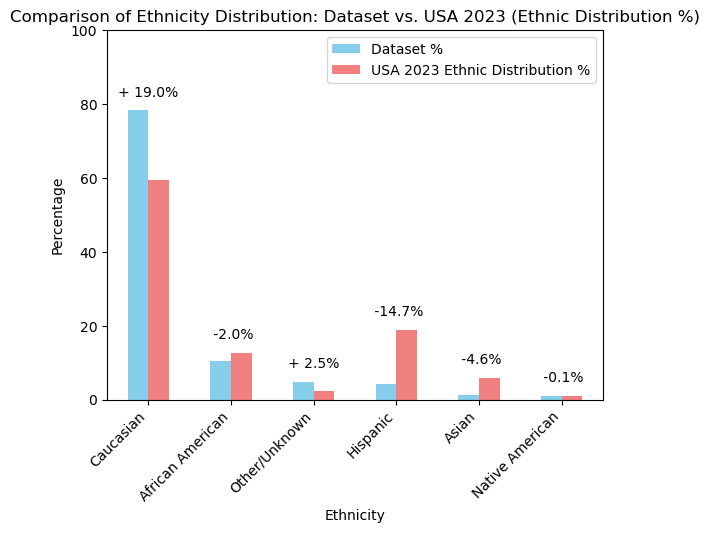

In [349]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named 'df'
plt.figure(figsize=(12, 8))

# Calculate the percentage distribution in the dataset
ethnicity_percentage_dataset = df['ethnicity'].value_counts(normalize=True) * 100

# USA 2023 ethnic distribution
usa_2023_ethnic_distribution = {'Caucasian': 59.3, 'African American': 12.6, 'Native American': 0.94,
                                 'Asian': 5.9, 'Hispanic': 18.9, 'Other/Unknown': 2.36}

# Create a DataFrame for USA 2023 ethnic distribution
usa_2023_df = pd.DataFrame(list(usa_2023_ethnic_distribution.items()), columns=['Ethnicity', 'USA 2023 Ethnic Distribution %'])
usa_2023_df.set_index('Ethnicity', inplace=True)

# Merge dataset and USA 2023 ethnic distribution DataFrames
merged_df = pd.concat([ethnicity_percentage_dataset, usa_2023_df], axis=1, sort=False)
merged_df.columns = ['Dataset %', 'USA 2023 Ethnic Distribution %']

# Plot the grouped bar chart
merged_df['Delta'] = merged_df['Dataset %'] - merged_df['USA 2023 Ethnic Distribution %']
bars = merged_df.loc[:,['Dataset %','USA 2023 Ethnic Distribution %']].plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Comparison of Ethnicity Distribution: Dataset vs. USA 2023 (Ethnic Distribution %)')
plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.ylim([0,100])

# Display the percentage values and delta on top of the bars
for i, (dataset_pct, usa_2023_pct, delta) in enumerate(zip(merged_df['Dataset %'], merged_df['USA 2023 Ethnic Distribution %'], merged_df['Delta'])):
    delta_text = f' {delta:.1f}%'
    if delta > 0:
        delta_text = '+' + delta_text
    plt.text(i, max(dataset_pct, usa_2023_pct) + 3, delta_text, ha='center', va='bottom', color='black')

plt.legend(loc='upper right')
plt.show()



## 7. Hospital mortality rate

we can see that there is single hospital with 50% to die, its important to note it has only 2 samples

In [244]:
print(f"there are {len(df['hospital_id'].unique())} unique hospitals")

there are 147 unique hospitals


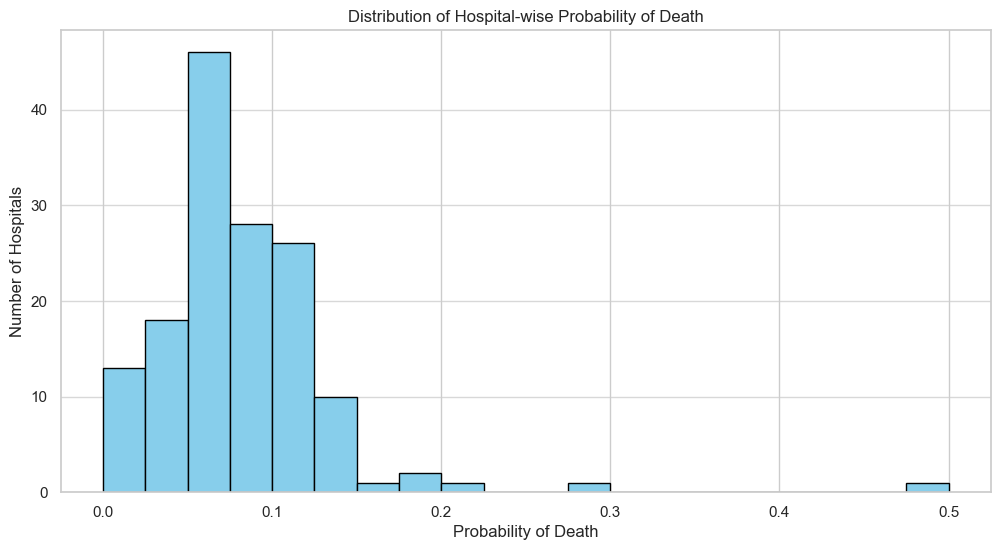

In [259]:
proportion=df.groupby('hospital_id')['hospital_death'].mean()
plt.figure(figsize=(12, 6))
plt.hist(df.groupby('hospital_id')['hospital_death'].mean(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Hospital-wise Probability of Death')
plt.xlabel('Probability of Death')
plt.ylabel('Number of Hospitals')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [267]:
df['ethnicity'].unique()

array(['Caucasian', nan, 'Hispanic', 'African American', 'Asian',
       'Native American', 'Other/Unknown'], dtype=object)

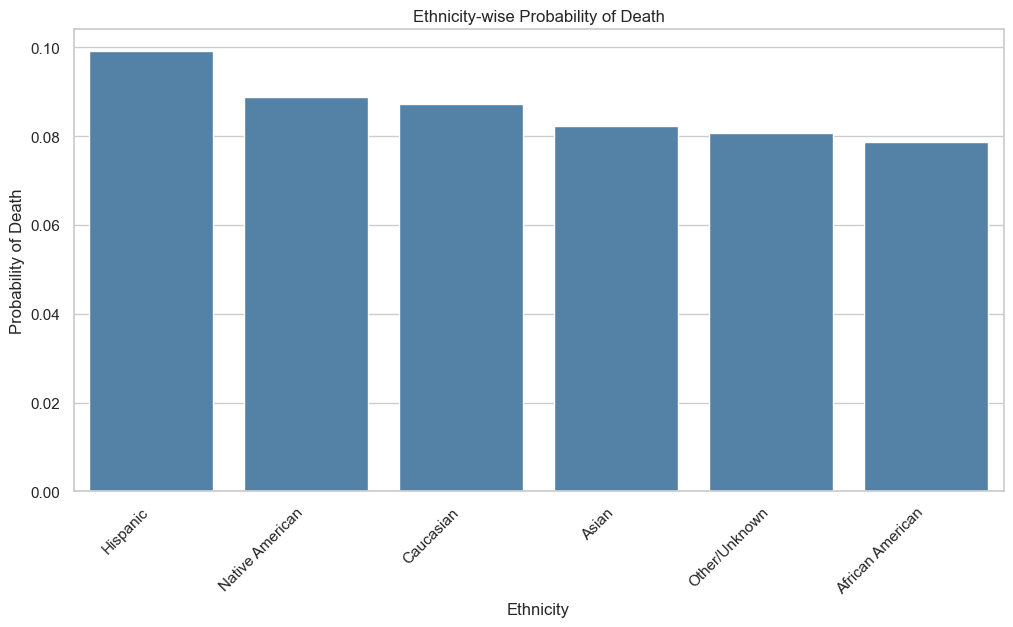

In [279]:
# Grouping data by ethnicity and calculating the mean death probability
ethnicity_death_prob = df.groupby('ethnicity')['hospital_death'].mean().reset_index()

# Sorting the data by death probability for better visualization
ethnicity_death_prob = ethnicity_death_prob.sort_values(by='hospital_death', ascending=False)

# Creating a bar plot
plt.figure(figsize=(12, 6))
sb.barplot(x='ethnicity', y='hospital_death', data=ethnicity_death_prob, color='#4682B4')
plt.title('Ethnicity-wise Probability of Death')
plt.xlabel('Ethnicity')
plt.ylabel('Probability of Death')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()